# Estadística básica con encuestas (Argentina 2025)
Cuaderno secuencial para explicar:
1) Medidas de tendencia central (media, mediana, moda, promedio ponderado)
2) Dispersión (desviación estándar, varianza, coeficiente de variación)
3) Distribuciones e **distribuciones acumuladas** (ECDF)
4) Distribución de frecuencias **condicionales** entre X e Y

Todos los ejemplos se basan en encuestas de opinión pública en Argentina 2025.

In [28]:
import math
from statistics import mean, median, variance, stdev
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True

# EJERCICIO 1 — Medidas de tendencia central con votos por mesa
120 mesas | votos para nuestro candidato por mesa (0–350).
Se generan varias distribuciones, se calculan media–mediana–moda y se grafica cada una.
Incluye: ejemplo secuencial (pocos valores) y un SANDBOX al final.

In [29]:

CAP_MESA = 350
N_MESAS  = 120

## Ejemplo secuencial (pocos valores)
Pequeño ejemplo con n impar para que la **mediana** sea entera.

In [30]:
ejemplo = [120, 140, 98, 132, 105, 150, 121]

suma = 0
for i, v in enumerate(ejemplo, start=1):
    antes = suma
    suma += v
    if i <= 5:
        print(f"Paso {i}: {antes} + {v} = {suma}")
    elif i == 6:
        print("... (pasos intermedios omitidos)")
media_ej = suma / len(ejemplo)
ordenados = sorted(ejemplo)
mediana_ej = ordenados[len(ordenados)//2]      # n impar → entero
moda_ej = Counter(ejemplo).most_common(1)[0][0]

print("\nResultados (ejemplo):")
print(f"  Media = {media_ej:.2f} | Mediana = {mediana_ej} | Moda = {moda_ej}")

Paso 1: 0 + 120 = 120
Paso 2: 120 + 140 = 260
Paso 3: 260 + 98 = 358
Paso 4: 358 + 132 = 490
Paso 5: 490 + 105 = 595
... (pasos intermedios omitidos)

Resultados (ejemplo):
  Media = 123.71 | Mediana = 121 | Moda = 120


## Presets de distribuciones (votos por mesa)
- **Movilización alta/baja (Binomial)**: p alta/baja → más/ménos votos esperados. Centro ≈ n·p.
- **Competida (Normal recortada)**: campana alrededor de μ, con σ moderada.
- **Sesgo alto/bajo (Beta)**: empuja la masa a valores altos o bajos.
- **Polarizada (Beta < 1)**: picos en los extremos (bimodal en los bordes).
Cada preset imprime **propiedades breves** y muestra **media, mediana y moda** en el gráfico.

In [31]:
PRESETS = {
    "movilizacion_alta": {
        "name": "Movilización alta (Binomial p=0.50)",
        "mode": "binomial", "N": N_MESAS, "SEED": 2025, "p": 0.50,
        "props": "p alta → centro ~ n·p (=175), var máx. en p=0.5."
    },
    "base_binomial": {
        "name": "Base (Binomial p=0.35)",
        "mode": "binomial", "N": N_MESAS, "SEED": 2025, "p": 0.35,
        "props": "apoyo moderado → centro ~ n·p (=122.5)."
    },
    "movilizacion_baja": {
        "name": "Movilización baja (Binomial p=0.20)",
        "mode": "binomial", "N": N_MESAS, "SEED": 2025, "p": 0.20,
        "props": "p baja → más masa en valores chicos (centro ~70)."
    },
    "competida_gauss": {
        "name": "Competida (Normal μ=120, σ=30)",
        "mode": "gauss", "N": N_MESAS, "SEED": 2025, "MU": 120, "SIGMA": 30,
        "props": "campana alrededor de μ; recortada a [0,350]."
    },
    "sesgo_alto_beta": {
        "name": "Sesgo a valores altos (Beta 5,2)",
        "mode": "beta", "N": N_MESAS, "SEED": 2025, "ALPHA": 5, "BETA": 2,
        "props": "empuja hacia valores altos (cola en bajos)."
    },
    "sesgo_bajo_beta": {
        "name": "Sesgo a valores bajos (Beta 2,5)",
        "mode": "beta", "N": N_MESAS, "SEED": 2025, "ALPHA": 2, "BETA": 5,
        "props": "empuja hacia valores bajos (cola en altos)."
    },
    "polarizada_beta": {
        "name": "Polarizada (Beta 0.6, 0.6)",
        "mode": "beta", "N": N_MESAS, "SEED": 2025, "ALPHA": 0.6, "BETA": 0.6,
        "props": "picos en 0 y 350; valle central (bimodal)."
    },
}
BAR_COLORS = {
    "movilizacion_alta": "#c7e9c0",
    "base_binomial":     "#9ecae1",
    "movilizacion_baja": "#fdae6b",
    "competida_gauss":   "#bcbddc",
    "sesgo_alto_beta":   "#fdd0a2",
    "sesgo_bajo_beta":   "#a1d99b",
    "polarizada_beta":   "#fb6a4a",
}

## Funciones

In [32]:
def _clip(x, lo=0, hi=CAP_MESA):
    return lo if x < lo else hi if x > hi else x

def generar_votos(pkg: dict):
    """Lista de enteros 0–350 (120 mesas) según paquete."""
    random.seed(pkg.get("SEED", None))
    N = int(pkg["N"])
    mode = pkg["mode"]
    out = []
    if mode == "binomial":
        p = float(pkg["p"])
        for _ in range(N):
            # simulación simple de Binomial(n=350, p)
            ex = sum(1 for _t in range(CAP_MESA) if random.random() < p)
            out.append(ex)
    elif mode == "gauss":
        mu, sig = float(pkg["MU"]), float(pkg["SIGMA"])
        for _ in range(N):
            out.append(_clip(round(random.gauss(mu, sig))))
    elif mode == "beta":
        a, b = float(pkg["ALPHA"]), float(pkg["BETA"])
        for _ in range(N):
            u = random.betavariate(a, b)
            out.append(_clip(round(u * CAP_MESA)))
    else:
        raise ValueError("mode inválido")
    return out

def mediana_discreta(xs):
    xs = sorted(xs); n = len(xs)
    # para n par tomamos el menor de los dos centrales (medida discreta)
    return xs[n//2 - 1] if n % 2 == 0 else xs[n//2]

def _bins(step=20):
    edges = list(range(0, CAP_MESA + step, step))
    if edges[-1] < CAP_MESA: edges.append(CAP_MESA)
    return edges

def top_modos(xs, bins, k=2):
    """Centros de los k bins más altos (modas tipo histograma)."""
    counts, edges = np.histogram(xs, bins=bins)
    idx = np.argsort(counts)[::-1]  # de mayor a menor
    modos = []
    maxc = counts[idx[0]]
    for j in idx:
        if counts[j] < maxc: break  # solo los máximos (empates)
        centro = (edges[j] + edges[j+1]) / 2
        modos.append(centro)
        if len(modos) == k: break
    return modos

def mostrar_distribucion(key: str):
    """Imprime propiedades + medidas y grafica 1 distribución por llamada."""
    pkg = PRESETS[key]
    vals = generar_votos(pkg)
    m = mean(vals)
    med = mediana_discreta(vals)
    bins = _bins(step=20)
    modos = top_modos(vals, bins, k=2)    # puede devolver 1 o 2 picos

    print(pkg["name"])
    print("Propiedades:", pkg["props"])
    print(f"Medidas → n={len(vals)} | Media={m:.2f} | Mediana={med} | Moda(s)~ {[int(round(x)) for x in modos]}\n")

    plt.hist(vals, bins=bins, align="mid", rwidth=0.9,
             color=BAR_COLORS[key], edgecolor="black", zorder=1)

    plt.axvline(m,   color="#FF00FF", linewidth=2.8, linestyle="--", label=f"Media {m:.2f}", zorder=3)
    plt.axvline(med, color="#00CFFF", linewidth=2.8, linestyle="-.", label=f"Mediana {med}", zorder=3)
    for j, mc in enumerate(modos, start=1):
        lab = f"Moda ~{int(round(mc))}" if j == 1 else f"Moda 2 ~{int(round(mc))}"
        plt.axvline(mc, color="#FF7F0E", linewidth=2.8, linestyle="-", label=lab, zorder=3)

    plt.title(pkg["name"])
    plt.xlabel("Votos para el candidato por mesa")
    plt.ylabel("Frecuencia (mesas)")
    plt.xlim(0, CAP_MESA)
    plt.legend()
    plt.show()

## Plots (llamar uno por vez)
Ejecuta una celda por distribución. Cada llamada imprime sus propiedades y medidas y dibuja el histograma.

Movilización alta (Binomial p=0.50)
Propiedades: p alta → centro ~ n·p (=175), var máx. en p=0.5.
Medidas → n=120 | Media=175.62 | Mediana=175 | Moda(s)~ [170]



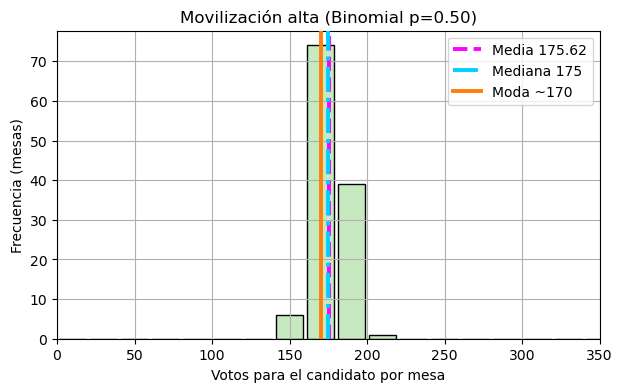

In [33]:
# movilización alta (p grande)
mostrar_distribucion("movilizacion_alta")

Base (Binomial p=0.35)
Propiedades: apoyo moderado → centro ~ n·p (=122.5).
Medidas → n=120 | Media=123.67 | Mediana=123 | Moda(s)~ [130]



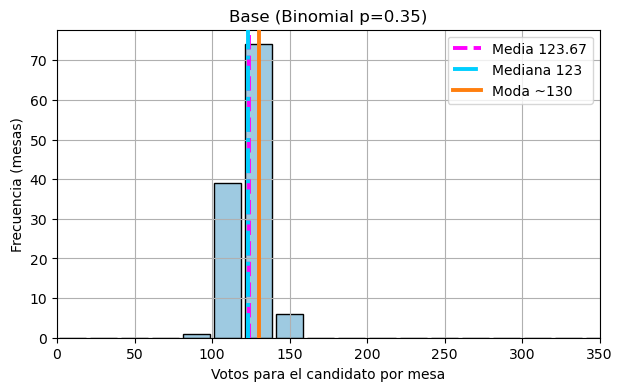

In [34]:
# base binomial (apoyo moderado)
mostrar_distribucion("base_binomial")

Movilización baja (Binomial p=0.20)
Propiedades: p baja → más masa en valores chicos (centro ~70).
Medidas → n=120 | Media=70.83 | Mediana=70 | Moda(s)~ [70]



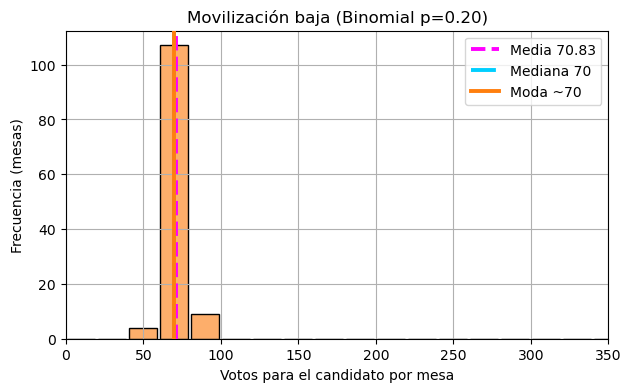

In [35]:
# movilización baja (p chica)
mostrar_distribucion("movilizacion_baja")

Competida (Normal μ=120, σ=30)
Propiedades: campana alrededor de μ; recortada a [0,350].
Medidas → n=120 | Media=117.77 | Mediana=115 | Moda(s)~ [110]



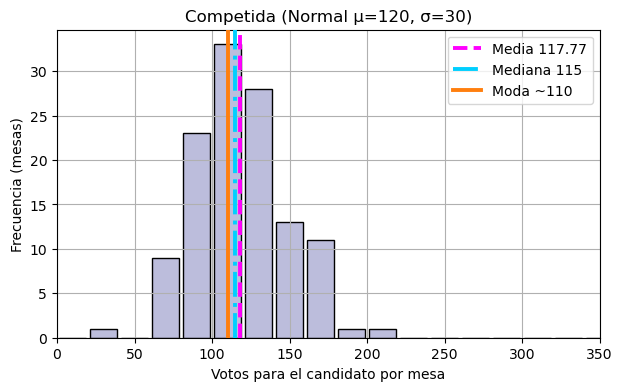

In [36]:
# competida (normal recortada)
mostrar_distribucion("competida_gauss")

Sesgo a valores altos (Beta 5,2)
Propiedades: empuja hacia valores altos (cola en bajos).
Medidas → n=120 | Media=246.25 | Mediana=259 | Moda(s)~ [310]



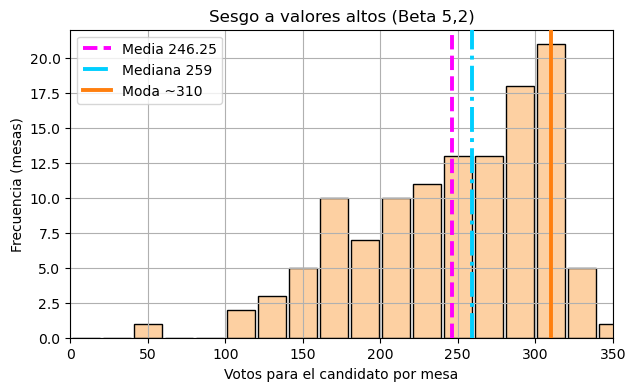

In [37]:
# sesgo a valores altos
mostrar_distribucion("sesgo_alto_beta")

Sesgo a valores bajos (Beta 2,5)
Propiedades: empuja hacia valores bajos (cola en altos).
Medidas → n=120 | Media=100.39 | Mediana=92 | Moda(s)~ [70]



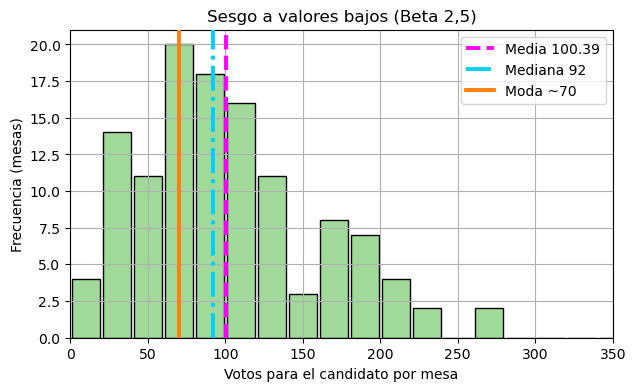

In [38]:
# sesgo a valores bajos
mostrar_distribucion("sesgo_bajo_beta")

Polarizada (Beta 0.6, 0.6)
Propiedades: picos en 0 y 350; valle central (bimodal).
Medidas → n=120 | Media=168.71 | Mediana=148 | Moda(s)~ [10]



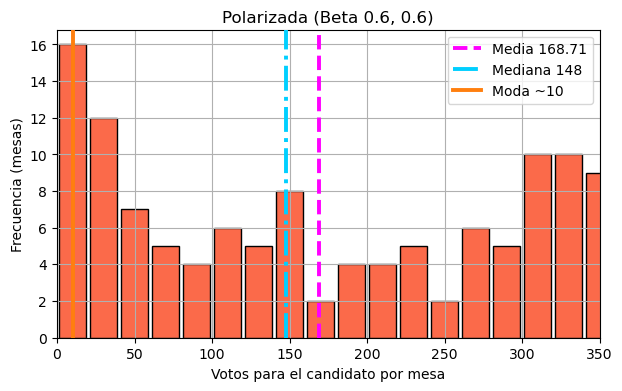

In [39]:
# polarizada (picos en extremos; pueden verse dos líneas naranjas si hay empate de picos)
mostrar_distribucion("polarizada_beta")

## SANDBOX — tu propia distribución
Edita el paquete y llama `mostrar_distribucion_sbx(SANDBOX)`.

In [40]:
SANDBOX = {
    "name": "Mi binomial competitiva (p=0.42)",
    "mode": "binomial", "N": N_MESAS, "SEED": 2025, "p": 0.42,
    "props": "p intermedia → centro ~ n·p (=147)."
    # Ejemplos:
    # {"name":"Mi normal (μ=180,σ=35)","mode":"gauss","N":N_MESAS,"SEED":2025,"MU":180,"SIGMA":35,"props":"campana centrada alta."}
    # {"name":"Mi beta (4.5,2.0)","mode":"beta","N":N_MESAS,"SEED":2025,"ALPHA":4.5,"BETA":2.0,"props":"sesgo alto."}
}

In [41]:
def mostrar_distribucion_sbx(pkg: dict, color="#6baed6"):
    vals = generar_votos(pkg)
    m = mean(vals)
    med = mediana_discreta(vals)
    bins = _bins(step=20)
    modos = top_modos(vals, bins, k=2)

    print(pkg["name"])
    if "props" in pkg: print("Propiedades:", pkg["props"])
    print(f"Medidas → n={len(vals)} | Media={m:.2f} | Mediana={med} | Moda(s)~ {[int(round(x)) for x in modos]}\n")

    plt.hist(vals, bins=bins, align="mid", rwidth=0.9,
             color=color, edgecolor="black", zorder=1)
    plt.axvline(m,   color="#FF00FF", linewidth=2.8, linestyle="--", label=f"Media {m:.2f}", zorder=3)
    plt.axvline(med, color="#00CFFF", linewidth=2.8, linestyle="-.", label=f"Mediana {med}", zorder=3)
    for j, mc in enumerate(modos, start=1):
        lab = f"Moda ~{int(round(mc))}" if j == 1 else f"Moda 2 ~{int(round(mc))}"
        plt.axvline(mc, color="#FF7F0E", linewidth=2.8, linestyle="-", label=lab, zorder=3)
    plt.title(pkg["name"])
    plt.xlabel("Votos para el candidato por mesa")
    plt.ylabel("Frecuencia (mesas)")
    plt.xlim(0, CAP_MESA)
    plt.legend()
    plt.show()

Mi binomial competitiva (p=0.42)
Propiedades: p intermedia → centro ~ n·p (=147).
Medidas → n=120 | Media=147.88 | Mediana=147 | Moda(s)~ [150]



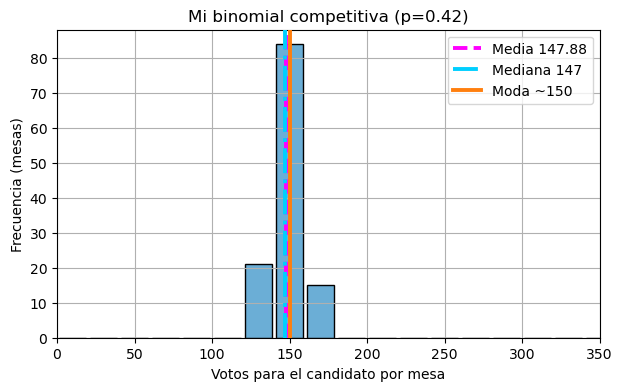

In [42]:
mostrar_distribucion_sbx(SANDBOX)
######################################################################################

# EJERCICIO 2 — Dispersión de **satisfacción** por municipio (PBA, 2025)
Variable: satisfacción (escala entera 1–10). Se definen municipios con medias y dispersiones distintas.
Cada plot se genera llamando a una función y muestra **media**, **desvío**, **varianza** y **coef. de variación (CV)**.
Al final hay un **SANDBOX** con parámetros simples: `media`, `sigma`, `n`.

## Presets (municipios con medias y dispersiones distintas)

In [43]:
MUNICIPIOS = {
    "La_Plata":      {"name": "La Plata",        "mu": 6.2, "sigma": 0.9, "n": 200, "seed": 2025,
                      "props": "media alta, baja dispersión"},
    "Mar_del_Plata": {"name": "Mar del Plata",   "mu": 5.8, "sigma": 1.3, "n": 200, "seed": 2025,
                      "props": "media media, dispersión moderada"},
    "Bahia_Blanca":  {"name": "Bahía Blanca",    "mu": 6.5, "sigma": 1.8, "n": 200, "seed": 2025,
                      "props": "media alta, dispersión alta"},
    "Quilmes":       {"name": "Quilmes",         "mu": 5.2, "sigma": 1.5, "n": 200, "seed": 2025,
                      "props": "media baja-media, dispersión media"},
    "Moreno":        {"name": "Moreno",          "mu": 4.8, "sigma": 1.7, "n": 200, "seed": 2025,
                      "props": "media baja, dispersión alta"},
    "San_Isidro":    {"name": "San Isidro",      "mu": 7.0, "sigma": 0.8, "n": 200, "seed": 2025,
                      "props": "media muy alta, baja dispersión"},
}
COLORS = {
    "La_Plata": "#6baed6",
    "Mar_del_Plata": "#74c476",
    "Bahia_Blanca": "#fd8d3c",
    "Quilmes": "#9e9ac8",
    "Moreno": "#fb6a4a",
    "San_Isidro": "#31a354",
}

## Utilidades

In [44]:
def _clip_1_10(x):  # recorta al rango 1..10
    return 1 if x < 1 else 10 if x > 10 else x

def simular_satisfaccion(mu: float, sigma: float, n: int, seed: int = 2025):
    random.seed(seed)
    datos = []
    for _ in range(n):
        x = round(random.gauss(mu, sigma))   # entero
        datos.append(_clip_1_10(x))
    return datos

def cv_porcentaje(xs):
    m = mean(xs)
    return float('nan') if m == 0 else (stdev(xs) / m) * 100

def plot_dispersion(xs, titulo, color):
    m  = mean(xs)
    sd = stdev(xs)
    var = variance(xs)
    cv = cv_porcentaje(xs)

    # Histograma (barras enteras 1..10)
    plt.hist(xs, bins=range(1,12), align="left", rwidth=0.85,
             color=color, edgecolor="black", zorder=1)
    # Líneas de media y ±1σ
    plt.axvline(m,      color="#FF00FF", linewidth=2.6, linestyle="--", label=f"Media {m:.2f}", zorder=3)
    plt.axvline(m - sd, color="#00CFFF", linewidth=2.0, linestyle="-.", label=f"−1σ {max(m-sd,1):.2f}", zorder=3)
    plt.axvline(m + sd, color="#00CFFF", linewidth=2.0, linestyle="-.", label=f"+1σ {min(m+sd,10):.2f}", zorder=3)

    plt.title(titulo)
    plt.xlabel("Satisfacción (1–10)")
    plt.ylabel("Frecuencia")
    plt.xticks(range(1,11))
    plt.legend()
    # Anotación CV
    plt.text(0.02, 0.95, f"Var={var:.2f} | σ={sd:.2f} | CV={cv:.1f}%",
             transform=plt.gca().transAxes, va="top", ha="left",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))
    plt.show()

def mostrar_municipio(key: str):
    cfg = MUNICIPIOS[key]
    xs  = simular_satisfaccion(cfg["mu"], cfg["sigma"], cfg["n"], cfg["seed"])
    print(f"{cfg['name']} — {cfg['props']}")
    print(f"n={len(xs)} | media={mean(xs):.2f} | σ={stdev(xs):.2f} | var={variance(xs):.2f} | CV={cv_porcentaje(xs):.1f}%\n")
    plot_dispersion(xs, f"Satisfacción — {cfg['name']}", COLORS[key])

## Plots 1 a 1 (ejecuta la(s) llamada(s) que desees)

La Plata — media alta, baja dispersión
n=200 | media=6.20 | σ=0.92 | var=0.84 | CV=14.8%



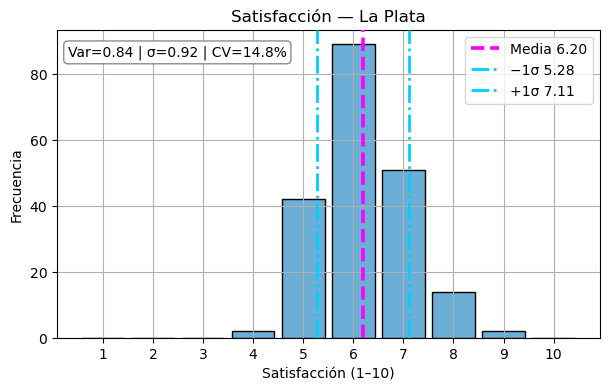

In [45]:
mostrar_municipio("La_Plata")

Mar del Plata — media media, dispersión moderada
n=200 | media=5.74 | σ=1.32 | var=1.75 | CV=23.1%



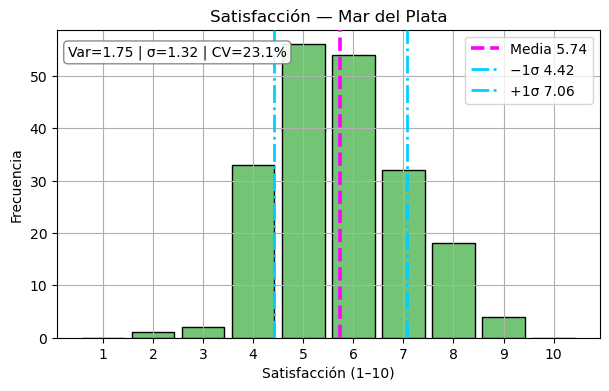

In [46]:
mostrar_municipio("Mar_del_Plata")

Bahía Blanca — media alta, dispersión alta
n=200 | media=6.40 | σ=1.75 | var=3.08 | CV=27.4%



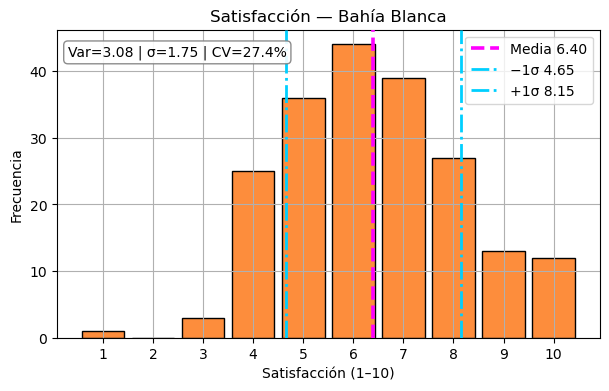

In [47]:
mostrar_municipio("Bahia_Blanca")

Quilmes — media baja-media, dispersión media
n=200 | media=5.13 | σ=1.51 | var=2.27 | CV=29.4%



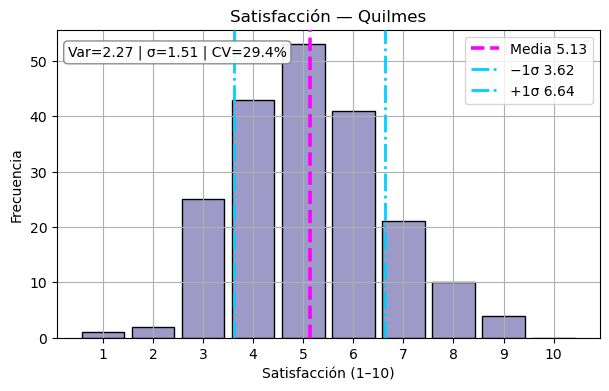

In [48]:
mostrar_municipio("Quilmes")

Moreno — media baja, dispersión alta
n=200 | media=4.76 | σ=1.67 | var=2.77 | CV=35.0%



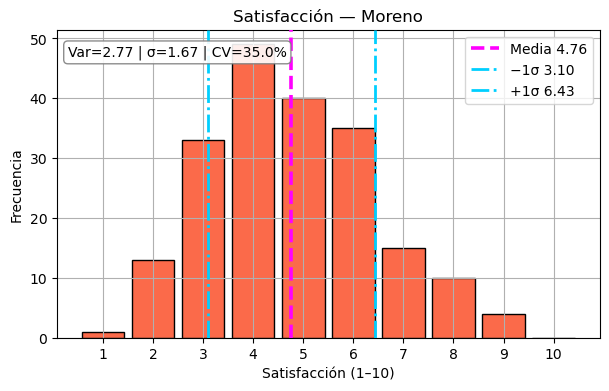

In [49]:
mostrar_municipio("Moreno")

San Isidro — media muy alta, baja dispersión
n=200 | media=6.96 | σ=0.81 | var=0.65 | CV=11.6%



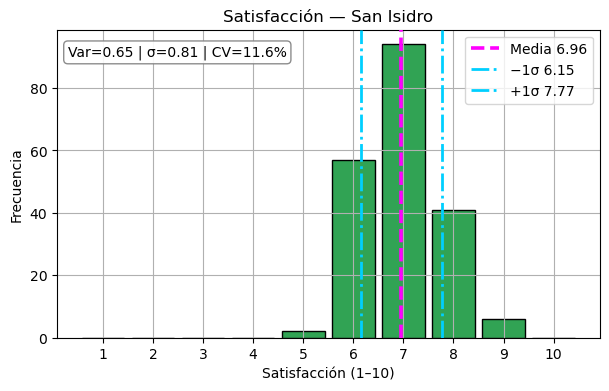

In [50]:
mostrar_municipio("San_Isidro")

## SANDBOX — parámetros simples
Cambia `media`, `sigma`, `n` (y opcional `seed`). Ejecuta estas dos celdas.

In [51]:
SANDBOX = {
    "name":  "Mi municipio (μ=6.3, σ=1.2, n=250)",
    "media": 5,
    "sigma": 4,
    "n":     250,
    "seed":  202,
    "color": "#1f77b4"
}

Mi municipio (μ=6.3, σ=1.2, n=250)
n=250 | media=4.99 | σ=3.04 | var=9.24 | CV=60.9%



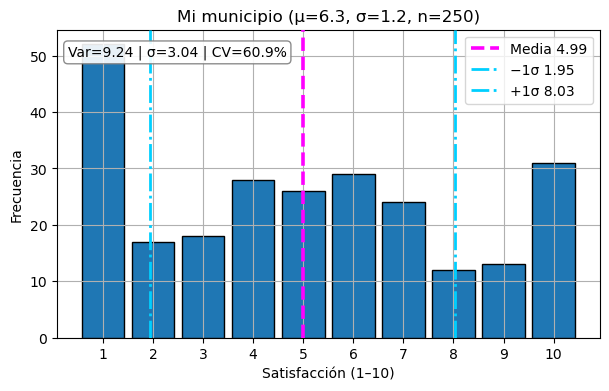

In [52]:
xs = simular_satisfaccion(SANDBOX["media"], SANDBOX["sigma"], SANDBOX["n"], SANDBOX["seed"])
print(f"{SANDBOX['name']}")
print(f"n={len(xs)} | media={mean(xs):.2f} | σ={stdev(xs):.2f} | var={variance(xs):.2f} | CV={cv_porcentaje(xs):.1f}%\n")
plot_dispersion(xs, SANDBOX["name"], SANDBOX["color"])

# EJERCICIO 3 — Frecuencia acumulada (ECDF) y **promedio ponderado por población**
Caso: **La Matanza (LM)** vs **San Isidro (SI)**, 2025.
Meta: mostrar que **M** puede tener **mayor media no ponderada**, pero al ponderar por población
(LM >> SI) el agregado favorece a **P**.



In [53]:
#------------------- Población usada para ponderar (tabla) --------------------
POB = {
    "La Matanza": 1_800_000,
    "San Isidro":   300_000,
}

print("Poblaciones para ponderación")
print("Municipio     | Población")
for k, v in POB.items():
    print(f"{k:12s} | {v:,}")
print()

Poblaciones para ponderación
Municipio     | Población
La Matanza   | 1,800,000
San Isidro   | 300,000



## 1) Simulación (reproducible)
Diseñamos medias para forzar el efecto:
- LM: **P** alto (≈7.2), **M** bajo (≈5.2)
- SI: **M** alto (≈7.4), **P** bajo (≈4.6)

In [54]:
def _clip_1_10(x): 
    return 1 if x < 1 else 10 if x > 10 else x

def simular(mu, sigma, n, seed):
    random.seed(seed)
    return [_clip_1_10(round(random.gauss(mu, sigma))) for _ in range(n)]

N_LM = 500
N_SI = 500

# La Matanza
LM_P = simular(mu=7.2, sigma=0.8, n=N_LM, seed=123)
LM_M = simular(mu=5.2, sigma=0.9, n=N_LM, seed=124)

# San Isidro
SI_P = simular(mu=4.6, sigma=0.8, n=N_SI, seed=223)
SI_M = simular(mu=7.4, sigma=0.8, n=N_SI, seed=224)

## 2) Tablas de **frecuencia relativa** y **acumulada** (por municipio y candidato)



In [55]:
def tablas(xs):
    vals = list(range(1, 11))
    c = Counter(xs)
    f_abs = [c.get(v, 0) for v in vals]
    tot = sum(f_abs)
    f_rel = [f/tot for f in f_abs]
    ac_rel = list(np.cumsum(f_rel))
    return vals, f_rel, ac_rel, tot

def imprimir_tabla(titulo, xs):
    vals, f_rel, ac_rel, tot = tablas(xs)
    print(f"{titulo}  | n={tot}")
    print("Valor |  f_rel% |  acum%")
    for v, fr, ar in zip(vals, f_rel, ac_rel):
        print(f"{v:>5} | {fr*100:7.2f} | {ar*100:7.2f}")
    print()

imprimir_tabla("La Matanza — P", LM_P)
imprimir_tabla("La Matanza — M", LM_M)
imprimir_tabla("San Isidro — P", SI_P)
imprimir_tabla("San Isidro — M", SI_M)

La Matanza — P  | n=500
Valor |  f_rel% |  acum%
    1 |    0.00 |    0.00
    2 |    0.00 |    0.00
    3 |    0.00 |    0.00
    4 |    0.00 |    0.00
    5 |    1.40 |    1.40
    6 |   16.20 |   17.60
    7 |   46.60 |   64.20
    8 |   30.80 |   95.00
    9 |    4.60 |   99.60
   10 |    0.40 |  100.00

La Matanza — M  | n=500
Valor |  f_rel% |  acum%
    1 |    0.00 |    0.00
    2 |    0.00 |    0.00
    3 |    3.00 |    3.00
    4 |   19.60 |   22.60
    5 |   39.40 |   62.00
    6 |   33.20 |   95.20
    7 |    4.80 |  100.00
    8 |    0.00 |  100.00
    9 |    0.00 |  100.00
   10 |    0.00 |  100.00

San Isidro — P  | n=500
Valor |  f_rel% |  acum%
    1 |    0.00 |    0.00
    2 |    0.40 |    0.40
    3 |    9.00 |    9.40
    4 |   36.40 |   45.80
    5 |   43.00 |   88.80
    6 |   11.00 |   99.80
    7 |    0.20 |  100.00
    8 |    0.00 |  100.00
    9 |    0.00 |  100.00
   10 |    0.00 |  100.00

San Isidro — M  | n=500
Valor |  f_rel% |  acum%
    1 |    0.00 |    

## 3) ECDF (una por municipio)



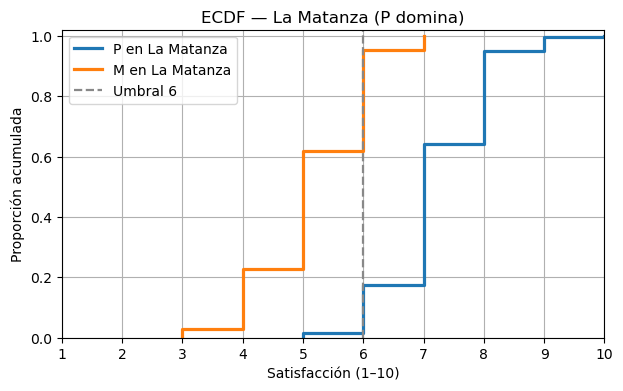

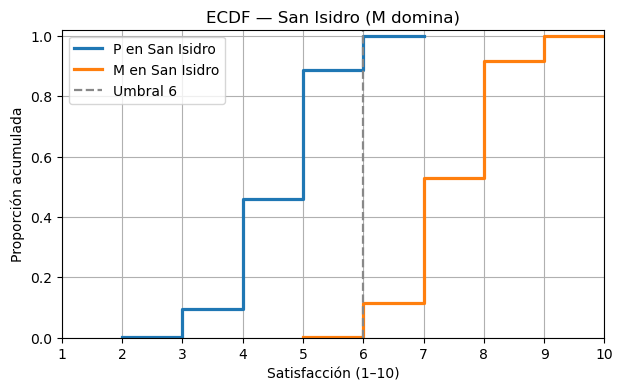

In [56]:
def plot_ecdf(d1, d2, lab1, lab2, titulo, color1, color2):
    x1 = sorted(d1); y1 = np.arange(1, len(x1)+1)/len(x1)
    x2 = sorted(d2); y2 = np.arange(1, len(x2)+1)/len(x2)
    plt.step(x1, y1, where="post", linewidth=2.3, label=lab1, color=color1)
    plt.step(x2, y2, where="post", linewidth=2.3, label=lab2, color=color2)
    plt.axvline(6, color="#888", linestyle="--", linewidth=1.6, label="Umbral 6")
    plt.title(titulo)
    plt.xlabel("Satisfacción (1–10)")
    plt.ylabel("Proporción acumulada")
    plt.xlim(1, 10); plt.ylim(0, 1.02); plt.legend(); plt.show()

plot_ecdf(LM_P, LM_M, "P en La Matanza", "M en La Matanza",
          "ECDF — La Matanza (P domina)", "#1f77b4", "#ff7f0e")

plot_ecdf(SI_P, SI_M, "P en San Isidro", "M en San Isidro",
          "ECDF — San Isidro (M domina)", "#1f77b4", "#ff7f0e")

## 4) Medias locales y comparación **no ponderada** vs **ponderada**
- **No ponderada**: promedio simple de las medias municipales (M gana).
- **Ponderada por población**: LM pesa mucho más → el agregado favorece a **P**.

In [57]:
# Medias locales
LM_P_mean, LM_M_mean = mean(LM_P), mean(LM_M)
SI_P_mean, SI_M_mean = mean(SI_P), mean(SI_M)

print("Medias locales")
print(f"  La Matanza:  P={LM_P_mean:.2f} | M={LM_M_mean:.2f}")
print(f"  San Isidro:  P={SI_P_mean:.2f} | M={SI_M_mean:.2f}\n")

# No ponderada (promedio simple de medias municipales)
P_unw = (LM_P_mean + SI_P_mean)/2
M_unw = (LM_M_mean + SI_M_mean)/2

# Ponderada por población
TOT_POP = POB["La Matanza"] + POB["San Isidro"]
P_w = (LM_P_mean*POB["La Matanza"] + SI_P_mean*POB["San Isidro"]) / TOT_POP
M_w = (LM_M_mean*POB["La Matanza"] + SI_M_mean*POB["San Isidro"]) / TOT_POP

print("Promedio de satisfacción — **antes** de ponderar (media simple de municipios)")
print(f"  P={P_unw:.2f}   |   M={M_unw:.2f}   →", "Gana M" if M_unw>P_unw else "Gana P")
print("\nPromedio de satisfacción — **ponderado por población**")
print(f"  P={P_w:.2f}   |   M={M_w:.2f}     →", "Gana M" if M_w>P_w else "Gana P")

# Lectura breve
print("\nLectura:")
print("• En SI, M tiene valores más altos; en LM, P es claramente superior (ver ECDFs).")
print("• Con la media **no ponderada** (promedio simple de municipios), M queda arriba.")
print("• Al **ponderar por población**, el peso demográfico de La Matanza invierte el resultado y favorece a P.")

Medias locales
  La Matanza:  P=7.22 | M=5.17
  San Isidro:  P=4.56 | M=7.44

Promedio de satisfacción — **antes** de ponderar (media simple de municipios)
  P=5.89   |   M=6.30   → Gana M

Promedio de satisfacción — **ponderado por población**
  P=6.84   |   M=5.50     → Gana P

Lectura:
• En SI, M tiene valores más altos; en LM, P es claramente superior (ver ECDFs).
• Con la media **no ponderada** (promedio simple de municipios), M queda arriba.
• Al **ponderar por población**, el peso demográfico de La Matanza invierte el resultado y favorece a P.


# EJERCICIO 4 — Probabilidades condicionales paso a paso (con tablas y totales)
**Ballotage 2023** · Voto a **Milei** vs **Massa**

Se usan **tablas de contingencia con totales** (pandas) y fórmulas explícitas.




In [58]:
plt.rcParams["figure.figsize"] = (8, 4.8)
plt.rcParams["axes.grid"] = True

#--------------- Escenario fijo (mismos datos en todos los pasos) ----------------
spec = {
    ("Urbana","Hombre"): {"n":  90, "p_milei": 0.49},
    ("Urbana","Mujer") : {"n": 810, "p_milei": 0.46},
    ("Rural", "Hombre"): {"n":  40, "p_milei": 0.80},
    ("Rural", "Mujer") : {"n":  60, "p_milei": 0.40},
}
ZONAS   = ["Urbana","Rural"]
GENEROS = ["Hombre","Mujer"]
VOTOS   = ["Milei","Massa"]

#xpandimos a un DataFrame de registros (n ≈ 1000)
rows = []
for (zona, genero), pars in spec.items():
    n = int(pars["n"])
    m = int(round(n*pars["p_milei"]))  # Milei
    a = n - m                          # Massa
    rows += [{"Zona": zona, "Género": genero, "Voto": "Milei"}]*m
    rows += [{"Zona": zona, "Género": genero, "Voto": "Massa"}]*a
df = pd.DataFrame(rows)
n_total = len(df)

## Paso 1 — **Solo ZONA** → `P(Voto \| Zona)`
Fórmula por zona \(z\):  
\[
P(\text{Milei}\mid z)=\frac{\text{cuentas de Milei en }z}{\text{total de casos en }z}
\]

In [59]:
# Conteos por Zona x Voto (con totales)
ct_z = pd.crosstab(df["Zona"], df["Voto"], margins=True, margins_name="Total")
ct_z

Voto,Massa,Milei,Total
Zona,,,
Rural,44,56,100
Urbana,483,417,900
Total,527,473,1000


In [60]:
# Probabilidades condicionales por fila: P(Voto | Zona) (con totales)
p_z = pd.crosstab(df["Zona"], df["Voto"], normalize="index", margins=True, margins_name="Total")
p_z.style.format("{:.2%}")

Voto,Massa,Milei
Zona,,
Rural,44.00%,56.00%
Urbana,53.67%,46.33%
Total,52.70%,47.30%


In [61]:
# Agregado ponderado por tamaño de zona (pesos = participación de cada zona en la muestra)
w_z = df["Zona"].value_counts(normalize=True).rename("Peso zona")
p_milei_z = p_z["Milei"].drop("Total")
p_agg_z = float((p_milei_z * w_z).sum())

tabla_z = pd.DataFrame({
    "P(Milei | Zona)": p_milei_z.map("{:.2%}".format),
    "Peso zona": w_z.map("{:.2%}".format),
})
tabla_z["Aporte"] = (p_milei_z * w_z).map("{:.2%}".format)

fila_agregado = pd.DataFrame([{
    "P(Milei | Zona)": "—",
    "Peso zona": "—",
    "Aporte": f"{p_agg_z:.2%}"
}], index=["Agregado"])

pd.concat([tabla_z, fila_agregado])

print(f"Agregado por zona: P(Milei) = {p_agg_z:.2%}  → {'Gana Milei' if p_agg_z>0.5 else 'Gana Massa'}")

Agregado por zona: P(Milei) = 47.30%  → Gana Massa


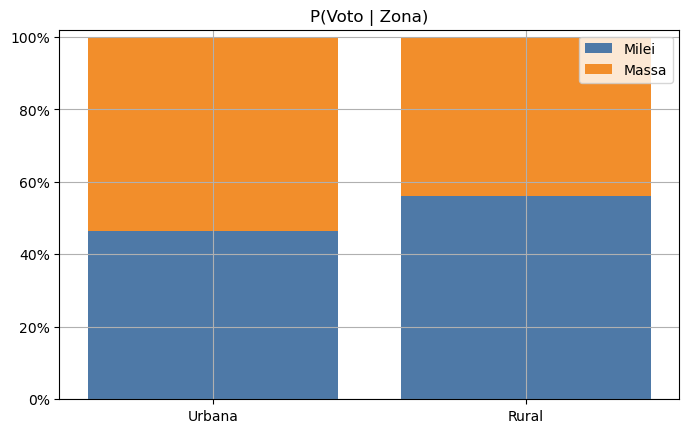

In [62]:
# Gráfico P(Voto|Zona)
x = np.arange(len(ZONAS))
pM = [p_milei_z[z] for z in ZONAS]
pA = [1-p for p in pM]
plt.bar(x, pM, label="Milei", color="#4e79a7")
plt.bar(x, pA, bottom=pM, label="Massa", color="#f28e2b")
plt.xticks(x, ZONAS)
plt.yticks(np.linspace(0,1,6), [f"{int(t*100)}%" for t in np.linspace(0,1,6)])
plt.ylim(0,1.02)
plt.title("P(Voto | Zona)")
plt.legend(); plt.show()

**Lectura:** mirando solo **Zona**, el gran peso de **Urbana** (con menor \(P(\text{Milei}|z)\)) inclina el agregado hacia **Massa**.

## Paso 2 — Agregamos **GÉNERO** y calculamos `P(Voto | Género)` y `P(Voto | Zona, Género)`

Fórmulas:

$$
P(\text{Milei}\mid g) \;=\; \frac{\sum_z \text{Milei}_{z,g}}{\sum_z n_{z,g}}, 
\qquad
P(\text{Milei}\mid z,g) \;=\; \frac{\text{Milei}_{z,g}}{n_{z,g}}
$$

In [63]:
# Conteos por Género x Voto (con totales)
ct_g = pd.crosstab(df["Género"], df["Voto"], margins=True, margins_name="Total")
ct_g

Voto,Massa,Milei,Total
Género,,,
Hombre,54,76,130
Mujer,473,397,870
Total,527,473,1000


In [64]:
# Probabilidades condicionales P(Voto | Género)
p_g = pd.crosstab(df["Género"], df["Voto"], normalize="index", margins=True, margins_name="Total")
p_g.style.format("{:.2%}")

Voto,Massa,Milei
Género,,
Hombre,41.54%,58.46%
Mujer,54.37%,45.63%
Total,52.70%,47.30%


In [65]:
# Conteos por (Zona,Género) x Voto (con totales)
ct_zg = pd.crosstab([df["Zona"], df["Género"]], df["Voto"], margins=True, margins_name="Total")
ct_zg

Voto           Massa  Milei  Total
Zona   Género                     
Rural  Hombre      8     32     40
       Mujer      36     24     60
Urbana Hombre     46     44     90
       Mujer     437    373    810
Total            527    473   1000

In [66]:
# Probabilidades P(Voto | Zona, Género)
p_zg = pd.crosstab([df["Zona"], df["Género"]], df["Voto"], normalize="index", margins=True, margins_name="Total")
p_zg.style.format("{:.2%}")

**Lectura intermedia:** al **condicionar por Género**, se ve que `P(Milei | Rural, Hombre)` es muy alta y
`P(Milei | Urbana, Mujer)` es baja (además son la mayoría de la muestra), explicando el sesgo del promedio por zona.

## Paso 3 — Reponderar por Género 50/50 con la misma evidencia condicional

Con $P(\text{Milei}\mid \text{Género})$ calculamos el agregado para un electorado balanceado: $w_H = w_M = 0.5$.

$$
P(\text{Milei}) \;=\; \sum_g P(\text{Milei}\mid g)\,\cdot\, w_g
$$

In [73]:
w_g_5050 = pd.Series({"Hombre": 0.5, "Mujer": 0.5}, name="Peso género (50/50)")
p_milei_g = p_g["Milei"].drop("Total")
p_agg_g_5050 = float((p_milei_g * w_g_5050).sum())

tabla_g = pd.DataFrame({
    "P(Milei | Género)": p_milei_g.map("{:.2%}".format),
    "Peso género (50/50)": w_g_5050.map("{:.2%}".format),
})
tabla_g["Aporte"] = (p_milei_g * w_g_5050).map("{:.2%}".format)

fila_agregado_g = pd.DataFrame([{
    "P(Milei | Género)": "—",
    "Peso género (50/50)": "—",
    "Aporte": f"{p_agg_g_5050:.2%}"
}], index=["Agregado"])

pd.concat([tabla_g, fila_agregado_g])

,P(Milei | Género),Peso género (50/50),Aporte
Hombre,58.46%,50.00%,29.23%
Mujer,45.63%,50.00%,22.82%
Agregado,—,—,52.05%


In [74]:
print(f"Agregado por **género balanceado**: P(Milei) = {p_agg_g_5050:.2%}  → "
      f"{'Gana Milei' if p_agg_g_5050>0.5 else 'Gana Massa'}")

Agregado por **género balanceado**: P(Milei) = 52.05%  → Gana Milei


**Lectura final**  
- Con `P(Voto|Zona)` y los **pesos de zona** de la muestra, el agregado favorecía a **Massa**.  
- Al incorporar `P(Voto|Género)` y **reponderar** el electorado a 50/50, el agregado se mueve y puede favorecer a **Milei**.  
- La conclusión depende de **qué variables condicionamos** y de los **pesos** usados al recombinar (zonas, géneros).